# Removing duplicates

In [6]:
using DIVAnd
using NCDatasets
using Dates
using Glob
using PyPlot
using PyCall
const plt = PyPlot
mpl = pyimport("matplotlib")
mpl.style.use("fairease.mplstyle")

In [2]:
datadir = "../data/NorthAdriatic/"
datafilelist = glob(joinpath(datadir, "*.nc"))
nfiles = length(datafilelist)
@info("Working on $(nfiles) files")
@show datafilelist

[ Info: Working on 4 files


datafilelist = ["../data/NorthAdriatic/NorthAdriaticSea_CORA_Profile_TEMP_19500101-20240101_0-500m.nc", "../data/NorthAdriatic/NorthAdriaticSea_Euro-Argo_TEMP_19500101-20240101_0-500m.nc", "../data/NorthAdriatic/NorthAdriaticSea_SeaDataNet_CDI_TS_ITS-90_water_temperature_19500101-20240101_0-500m.nc", "../data/NorthAdriatic/NorthAdriaticSea_World_Ocean_Database_Temperature_19500101-20240101_0-500m.nc"]


4-element Vector{String}:
 "../data/NorthAdriatic/NorthAdri" ⋯ 22 bytes ⋯ "EMP_19500101-20240101_0-500m.nc"
 "../data/NorthAdriatic/NorthAdri" ⋯ 19 bytes ⋯ "EMP_19500101-20240101_0-500m.nc"
 "../data/NorthAdriatic/NorthAdri" ⋯ 47 bytes ⋯ "ure_19500101-20240101_0-500m.nc"
 "../data/NorthAdriatic/NorthAdri" ⋯ 37 bytes ⋯ "ure_19500101-20240101_0-500m.nc"

In [52]:
regiontest = [13.5, 14., 44., 44.5]
regiontest = [11., 19., 42., 47.]

4-element Vector{Float64}:
 11.0
 19.0
 42.0
 47.0

## Read data from all the data files
We create arrays of arrays for the coordinates and the observations. 

In [53]:
# Allocate vectors of vectors
lonall = Vector{Vector{Float64}}(undef, nfiles)
latall = Vector{Vector{Float64}}(undef, nfiles)
timesall = Vector{Vector{DateTime}}(undef, nfiles)
depthall = Vector{Vector{Float64}}(undef, nfiles)
obsall = Vector{Vector{Float64}}(undef, nfiles)

for (iii, datafile) in enumerate(datafilelist)
    @info("Working on file $(basename(datafile))")
    
    dateref = Dates.DateTime(1950, 1, 1)
    
    if occursin("World_Ocean_Database", basename(datafile))
        dateref = Dates.DateTime(1770, 1, 1)
    elseif occursin("EMODnet Chemistry", basename(datafile)) 
        dateref = Dates.DateTime(1921, 1, 1)
    end
    
    NCDataset(datafile, "r") do ds
        
        # Select subregion
        lon = ds["LONGITUDE"][:]
        lat = ds["LATITUDE"][:]
        goodcoords = findall((lon .>= regiontest[1]) .& (lon .<= regiontest[2]) .& 
                             (lat .>= regiontest[3]) .& (lat .<= regiontest[4]))
        
        lonall[iii] = ds["LONGITUDE"][goodcoords]
        latall[iii] = ds["LATITUDE"][goodcoords]
        depthall[iii] = ds["DEPTH"][goodcoords]
        
        if ds["TIME"][:] isa Vector{Float64}
            @info(extrema(ds["TIME"][:]))
            # Convert to DateTime
            timesall[iii] = dateref .+ Millisecond.(round.(ds["TIME"][goodcoords] .* 86400 .* 1000))
            
        elseif ds["TIME"][:] isa Vector{String}
            @info("Need to convert to Datatime object")
            df = dateformat"y-m-dTH:M:S"
            timesall[iii] = DateTime.(ds["TIME"][goodcoords], df)
        end
        
        
        obsall[iii] = ds[keys(ds)[1]][goodcoords]
    end
end

[ Info: Working on file NorthAdriaticSea_CORA_Profile_TEMP_19500101-20240101_0-500m.nc
[ Info: (35.791666666666664, 24454.402141203704)
[ Info: Working on file NorthAdriaticSea_Euro-Argo_TEMP_19500101-20240101_0-500m.nc
[ Info: (22003.481064814816, 27025.264814814815)
[ Info: Working on file NorthAdriaticSea_SeaDataNet_CDI_TS_ITS-90_water_temperature_19500101-20240101_0-500m.nc
[ Info: Need to convert to Datatime object
[ Info: Working on file NorthAdriaticSea_World_Ocean_Database_Temperature_19500101-20240101_0-500m.nc
[ Info: (65778.79166668653, 92768.265625)


## Some plots to check
### Time histograms

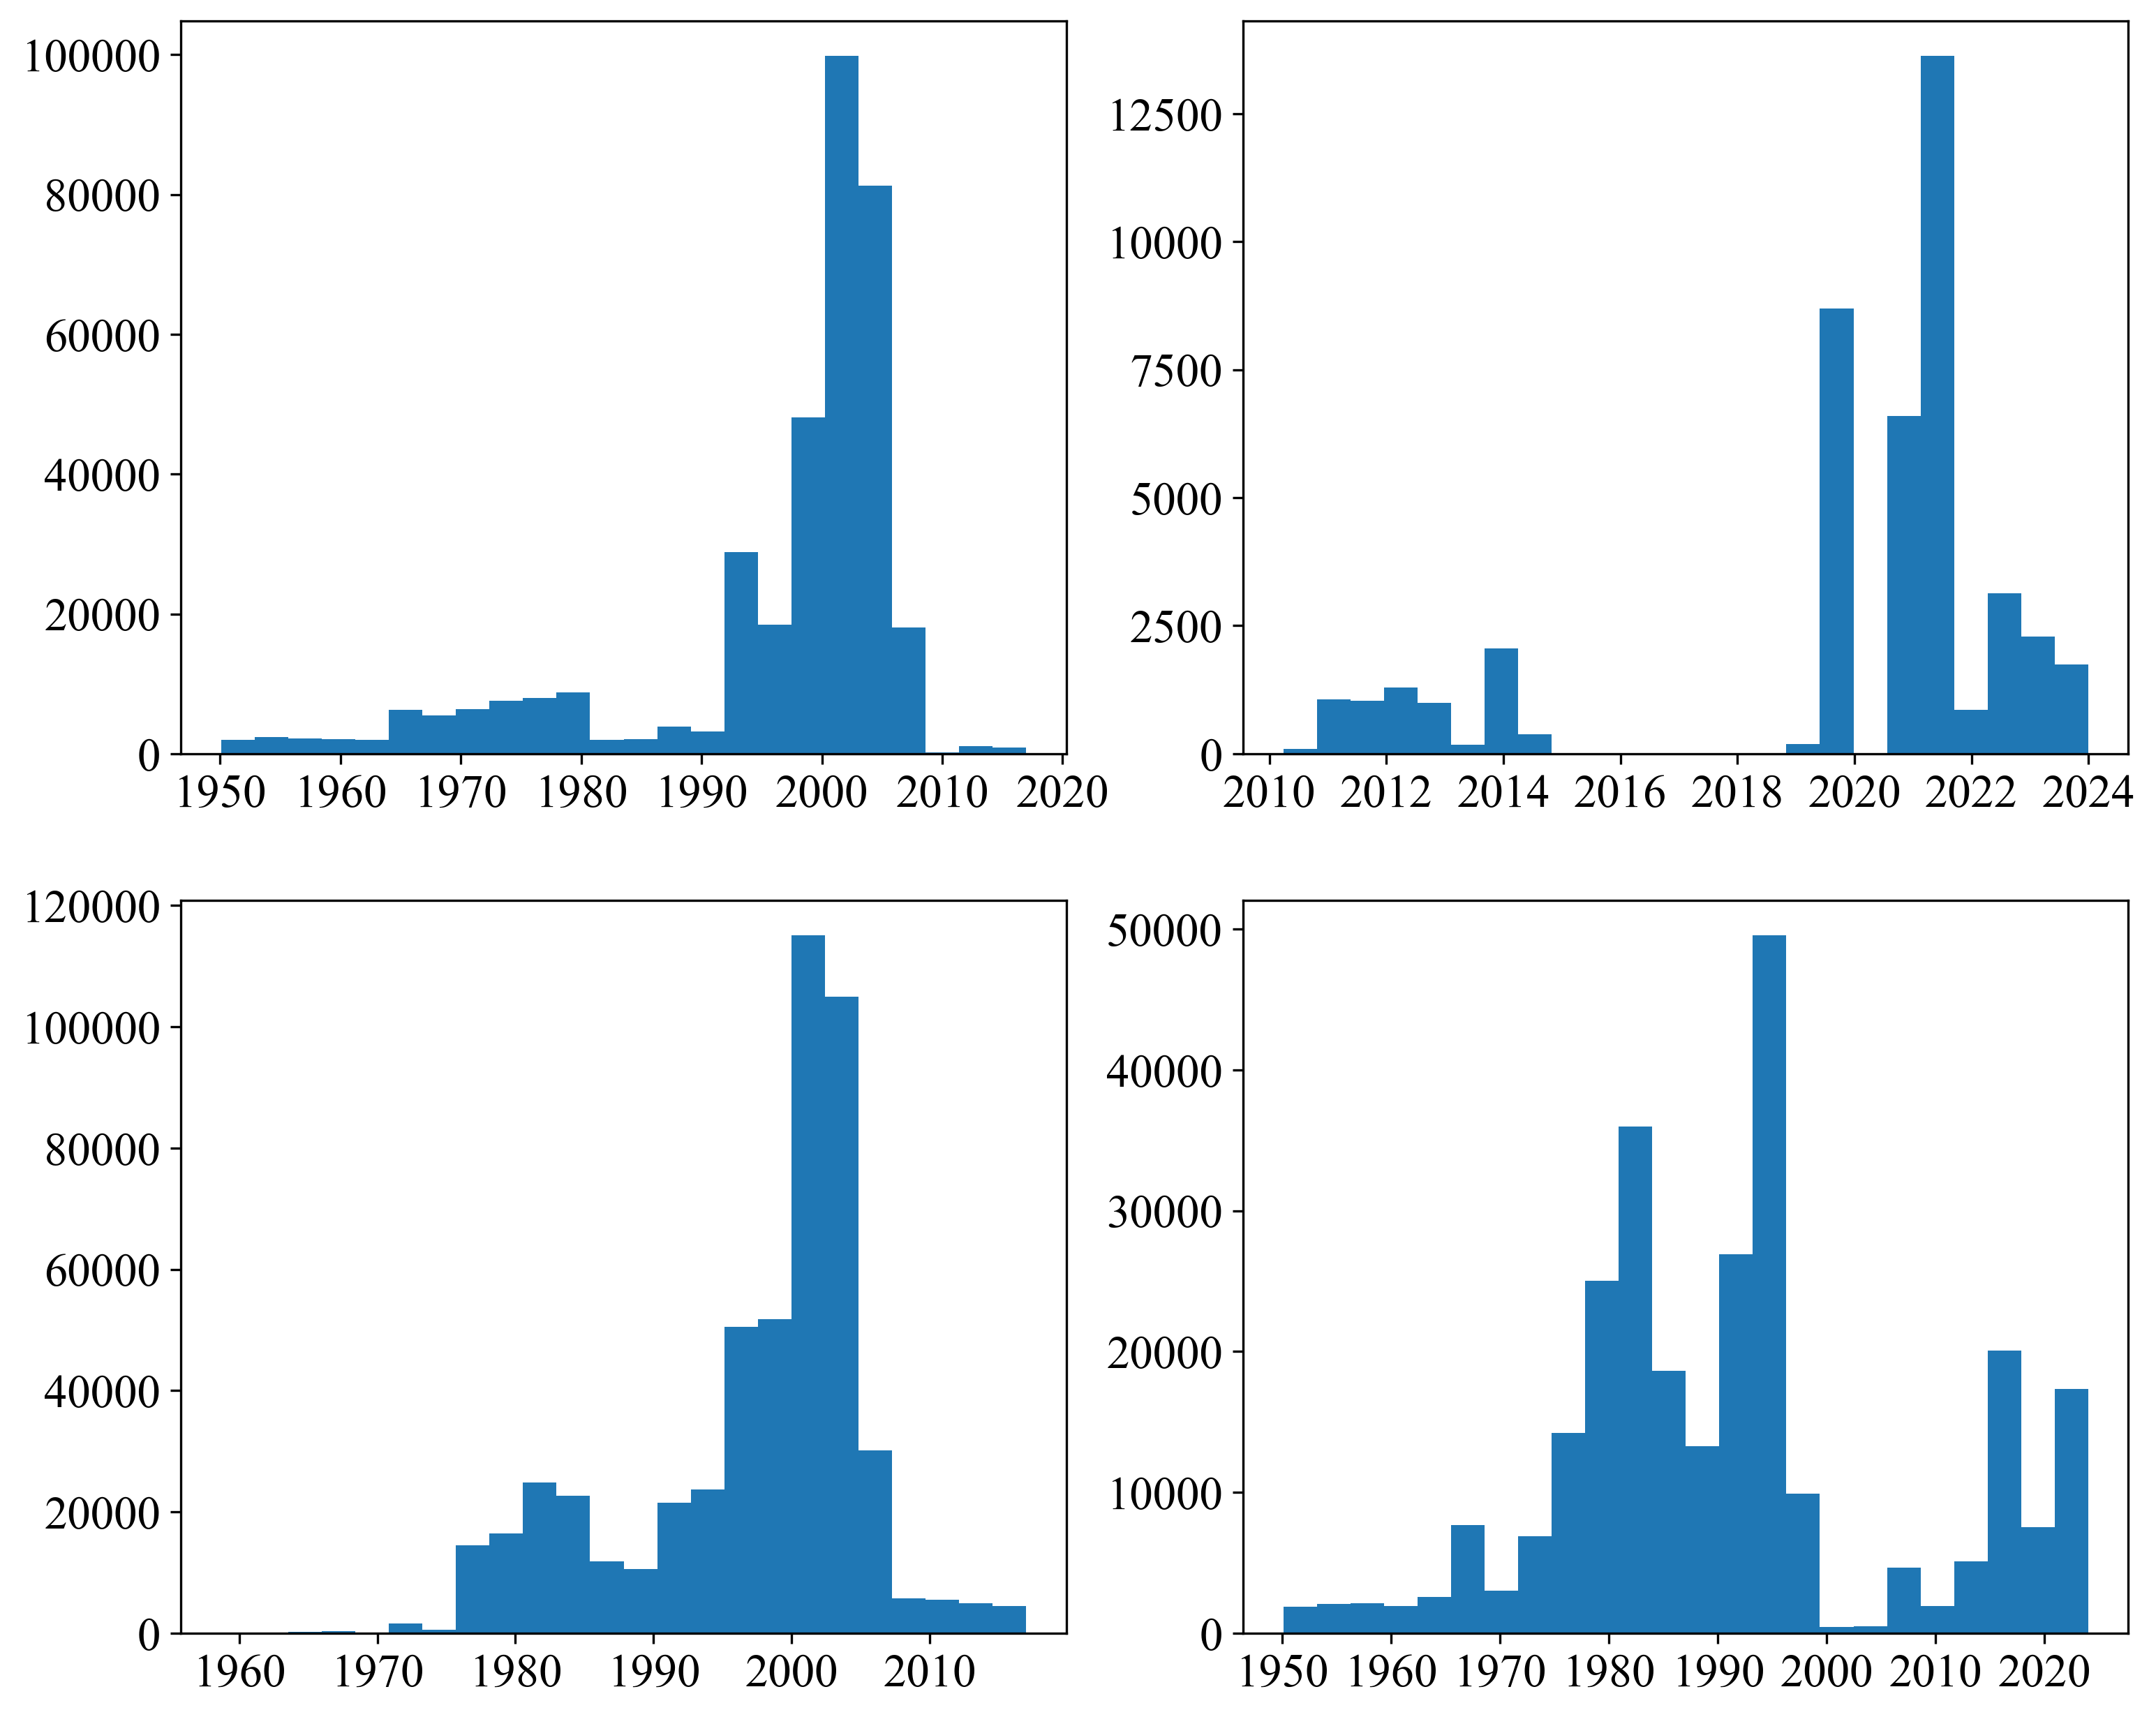

In [54]:
fig = plt.figure(figsize=(12, 10))
for ii = 1:nfiles
    ax = plt.subplot(2,2,ii)
    ax.hist(timesall[ii], bins=24)
end
plt.show()

In [55]:
extrema.(obsall)

4-element Vector{Tuple{Float64, Float64}}:
 (0.0, 29.989999771118164)
 (-0.010101010091602802, 27.82900047302246)
 (0.0, 10000.0)
 (0.0, 37.779998779296875)

### Map

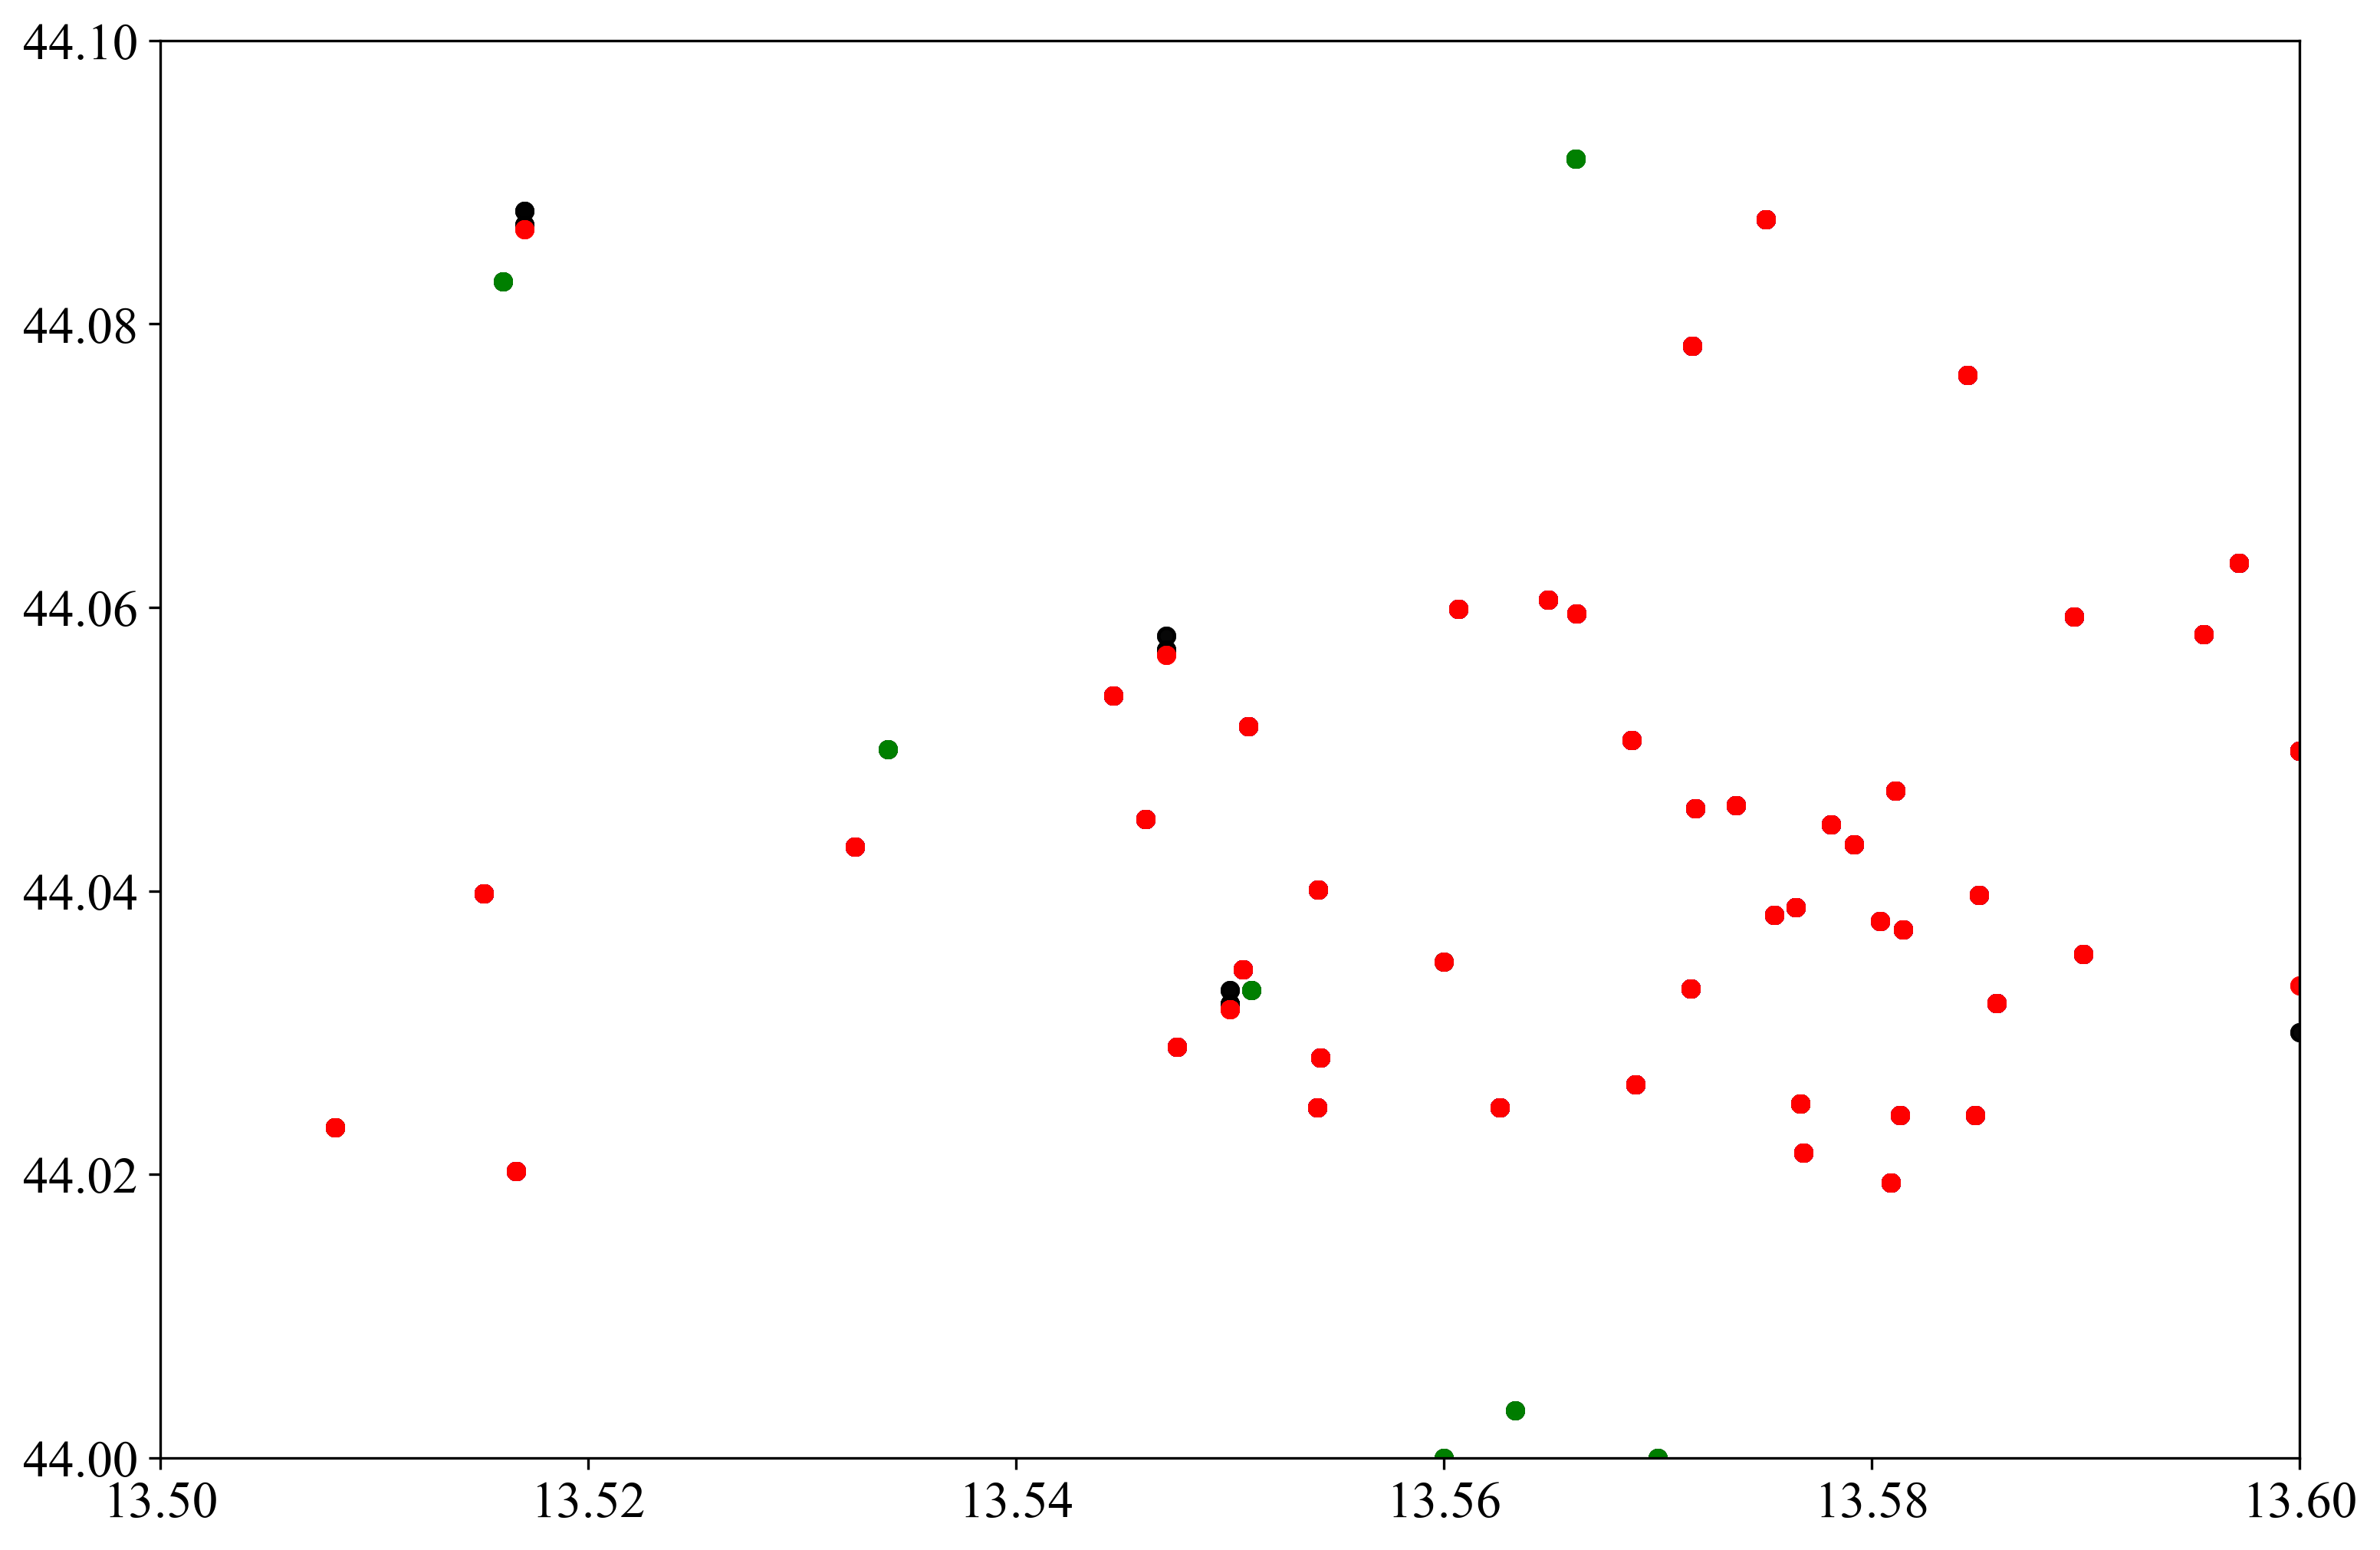

In [56]:
colorlist = ["k", "b", "g", "r"]
fig = plt.figure()
ax = plt.subplot(111)
for ii = 1:nfiles
    ax.plot(lonall[ii], latall[ii], "o", ms=5, alpha=0.5, color=colorlist[ii]) 
end
ax.set_xlim(13.5, 13.6)
ax.set_ylim(44., 44.1)
plt.show()

# Duplicate detection
### Set parameters
The setting of the parameters is key: chosing too small values will lead to zero duplicate detected; too large values will lead to too much duplicates to be removed.

In [57]:
Δlon = 0.01
Δlat = 0.01
Δdepth = 0.1
Δtime = 0.0
Δvar = 0.01

0.01

In [58]:
function merge_datasets(lonall::Vector{Vector{Float64}}, latall::Vector{Vector{Float64}}, 
        depthall::Vector{Vector{Float64}}, timesall::Vector{Vector{DateTime}}, 
        obsall:: Vector{Vector{Float64}}, Δlon::Float64, Δlat::Float64, Δdepth::Float64, 
        Δtime::Float64, Δvar::Float64)
    
    pct = []

    dupl = DIVAnd.Quadtrees.checkduplicates((lonall[1], latall[1], depthall[1], timesall[1]), obsall[1],
                                            (lonall[2], latall[2], depthall[2], timesall[2]), obsall[2],
                                            (Δlon, Δlat, Δdepth, Δtime), Δvar);

    index = findall(.!isempty.(dupl))
    newpoints = findall(isempty.(dupl))
    ndupl = length(index)
    pcdupl = round(ndupl / length(lonall[2]) * 100; digits=2);
    push!(pct, pcdupl)
    @info("Number of possible duplicates: $ndupl")
    @info("Percentage of duplicates: $pcdupl%")

    # Merging
    lons = vcat(lonall[1], lonall[2][newpoints])
    lats = vcat(latall[1], latall[2][newpoints])
    depths = vcat(depthall[1], depthall[2][newpoints])
    times = vcat(timesall[1], timesall[2][newpoints])
    obs = vcat(obsall[1], obsall[2][newpoints])

    dupl2 = DIVAnd.Quadtrees.checkduplicates((lons, lats, depths, times), obs,
                                            (lonall[3], latall[3], depthall[3], timesall[3]), obsall[3],
                                            (Δlon, Δlat, Δdepth, Δtime), Δvar);

    index = findall(.!isempty.(dupl2))
    newpoints = findall(isempty.(dupl2))
    ndupl = length(index)
    pcdupl = round(ndupl / length(lonall[3]) * 100; digits=2);
    push!(pct, pcdupl)
    @info("Number of possible duplicates: $ndupl")
    @info("Percentage of duplicates: $pcdupl%")

    # Merging
    lons = vcat(lons, lonall[3][newpoints])
    lats = vcat(lats, latall[3][newpoints])
    depths = vcat(depths, depthall[3][newpoints])
    times = vcat(times, timesall[3][newpoints])
    obs = vcat(obs, obsall[3][newpoints])

    dupl3 = DIVAnd.Quadtrees.checkduplicates((lons, lats, depths, times), obs,
                                            (lonall[4], latall[4], depthall[4], timesall[4]), obsall[4],
                                            (Δlon, Δlat, Δdepth, Δtime), Δvar);

    index = findall(.!isempty.(dupl3))
    newpoints = findall(isempty.(dupl3))
    ndupl = length(index)
    pcdupl = round(ndupl / length(lonall[4]) * 100; digits=2);
    push!(pct, pcdupl)
    @info("Number of possible duplicates: $ndupl")
    @info("Percentage of duplicates: $pcdupl%")

    lons = vcat(lons, lonall[4][newpoints])
    lats = vcat(lats, latall[4][newpoints])
    depths = vcat(depths, depthall[4][newpoints])
    times = vcat(times, timesall[4][newpoints])
    obs = vcat(obs, obsall[4][newpoints])
    
    return lons::Vector{Float64}, lats::Vector{Float64}, depths::Vector{Float64}, 
    times::Vector{DateTime}, obs::Vector{Float64}, pct::Vector
end

merge_datasets (generic function with 1 method)

In [59]:
Δtime = 0.1
for Δlon in [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
    Δlat = Δlon
    @time obslon, obslat, obsdepth, obstime, obsval, pct = merge_datasets(lonall, latall, depthall, timesall, 
        obsall, Δlon, Δlat, Δdepth, Δtime, Δvar);
    @info(Δlon, pct)
end

[ Info: Number of possible duplicates: 0
[ Info: Percentage of duplicates: 0.0%
[ Info: Number of possible duplicates: 302834
[ Info: Percentage of duplicates: 58.01%


 23.402560 seconds (9.03 M allocations: 3.621 GiB, 7.05% gc time)


[ Info: Number of possible duplicates: 180943
[ Info: Percentage of duplicates: 64.8%
┌ Info: 0.0005
│   pct =
│    3-element Vector{Any}:
│      0.0
│     58.01
└     64.8
[ Info: Number of possible duplicates: 0
[ Info: Percentage of duplicates: 0.0%
[ Info: Number of possible duplicates: 302870
[ Info: Percentage of duplicates: 58.01%


 24.885077 seconds (9.15 M allocations: 3.624 GiB, 6.66% gc time)


[ Info: Number of possible duplicates: 195763
[ Info: Percentage of duplicates: 70.11%
┌ Info: 0.001
│   pct =
│    3-element Vector{Any}:
│      0.0
│     58.01
└     70.11
[ Info: Number of possible duplicates: 0
[ Info: Percentage of duplicates: 0.0%
[ Info: Number of possible duplicates: 303396
[ Info: Percentage of duplicates: 58.11%


 24.270445 seconds (9.40 M allocations: 3.628 GiB, 5.74% gc time)


[ Info: Number of possible duplicates: 226233
[ Info: Percentage of duplicates: 81.02%
┌ Info: 0.005
│   pct =
│    3-element Vector{Any}:
│      0.0
│     58.11
└     81.02
[ Info: Number of possible duplicates: 0
[ Info: Percentage of duplicates: 0.0%
[ Info: Number of possible duplicates: 303916
[ Info: Percentage of duplicates: 58.21%


 32.251174 seconds (9.40 M allocations: 3.628 GiB, 6.39% gc time)


[ Info: Number of possible duplicates: 226257
[ Info: Percentage of duplicates: 81.03%
┌ Info: 0.01
│   pct =
│    3-element Vector{Any}:
│      0.0
│     58.21
└     81.03
[ Info: Number of possible duplicates: 0
[ Info: Percentage of duplicates: 0.0%
[ Info: Number of possible duplicates: 304571
[ Info: Percentage of duplicates: 58.34%


 47.667069 seconds (9.41 M allocations: 3.629 GiB, 4.32% gc time)


[ Info: Number of possible duplicates: 226340
[ Info: Percentage of duplicates: 81.06%
┌ Info: 0.05
│   pct =
│    3-element Vector{Any}:
│      0.0
│     58.34
└     81.06
[ Info: Number of possible duplicates: 0
[ Info: Percentage of duplicates: 0.0%
[ Info: Number of possible duplicates: 304658
[ Info: Percentage of duplicates: 58.35%


 38.479996 seconds (9.42 M allocations: 3.632 GiB, 3.97% gc time)


[ Info: Number of possible duplicates: 226348
[ Info: Percentage of duplicates: 81.06%
┌ Info: 0.1
│   pct =
│    3-element Vector{Any}:
│      0.0
│     58.35
└     81.06
[ Info: Number of possible duplicates: 0
[ Info: Percentage of duplicates: 0.0%
[ Info: Number of possible duplicates: 304739
[ Info: Percentage of duplicates: 58.37%


 92.018143 seconds (9.43 M allocations: 3.646 GiB, 1.53% gc time)


[ Info: Number of possible duplicates: 226425
[ Info: Percentage of duplicates: 81.09%
┌ Info: 0.5
│   pct =
│    3-element Vector{Any}:
│      0.0
│     58.37
└     81.09


In [60]:
Δlon = 0.002
Δlat = 0.002
Δdepth = 0.1
Δtime = 0.1
Δvar = 0.005

@time obslon, obslat, obsdepth, obstime, obsval, pct = merge_datasets(lonall, latall, depthall, timesall, 
        obsall, Δlon, Δlat, Δdepth, Δtime, Δvar);

[ Info: Number of possible duplicates: 0
[ Info: Percentage of duplicates: 0.0%
[ Info: Number of possible duplicates: 302990
[ Info: Percentage of duplicates: 58.04%


 24.773386 seconds (9.36 M allocations: 3.628 GiB, 5.96% gc time)


[ Info: Number of possible duplicates: 221302
[ Info: Percentage of duplicates: 79.25%


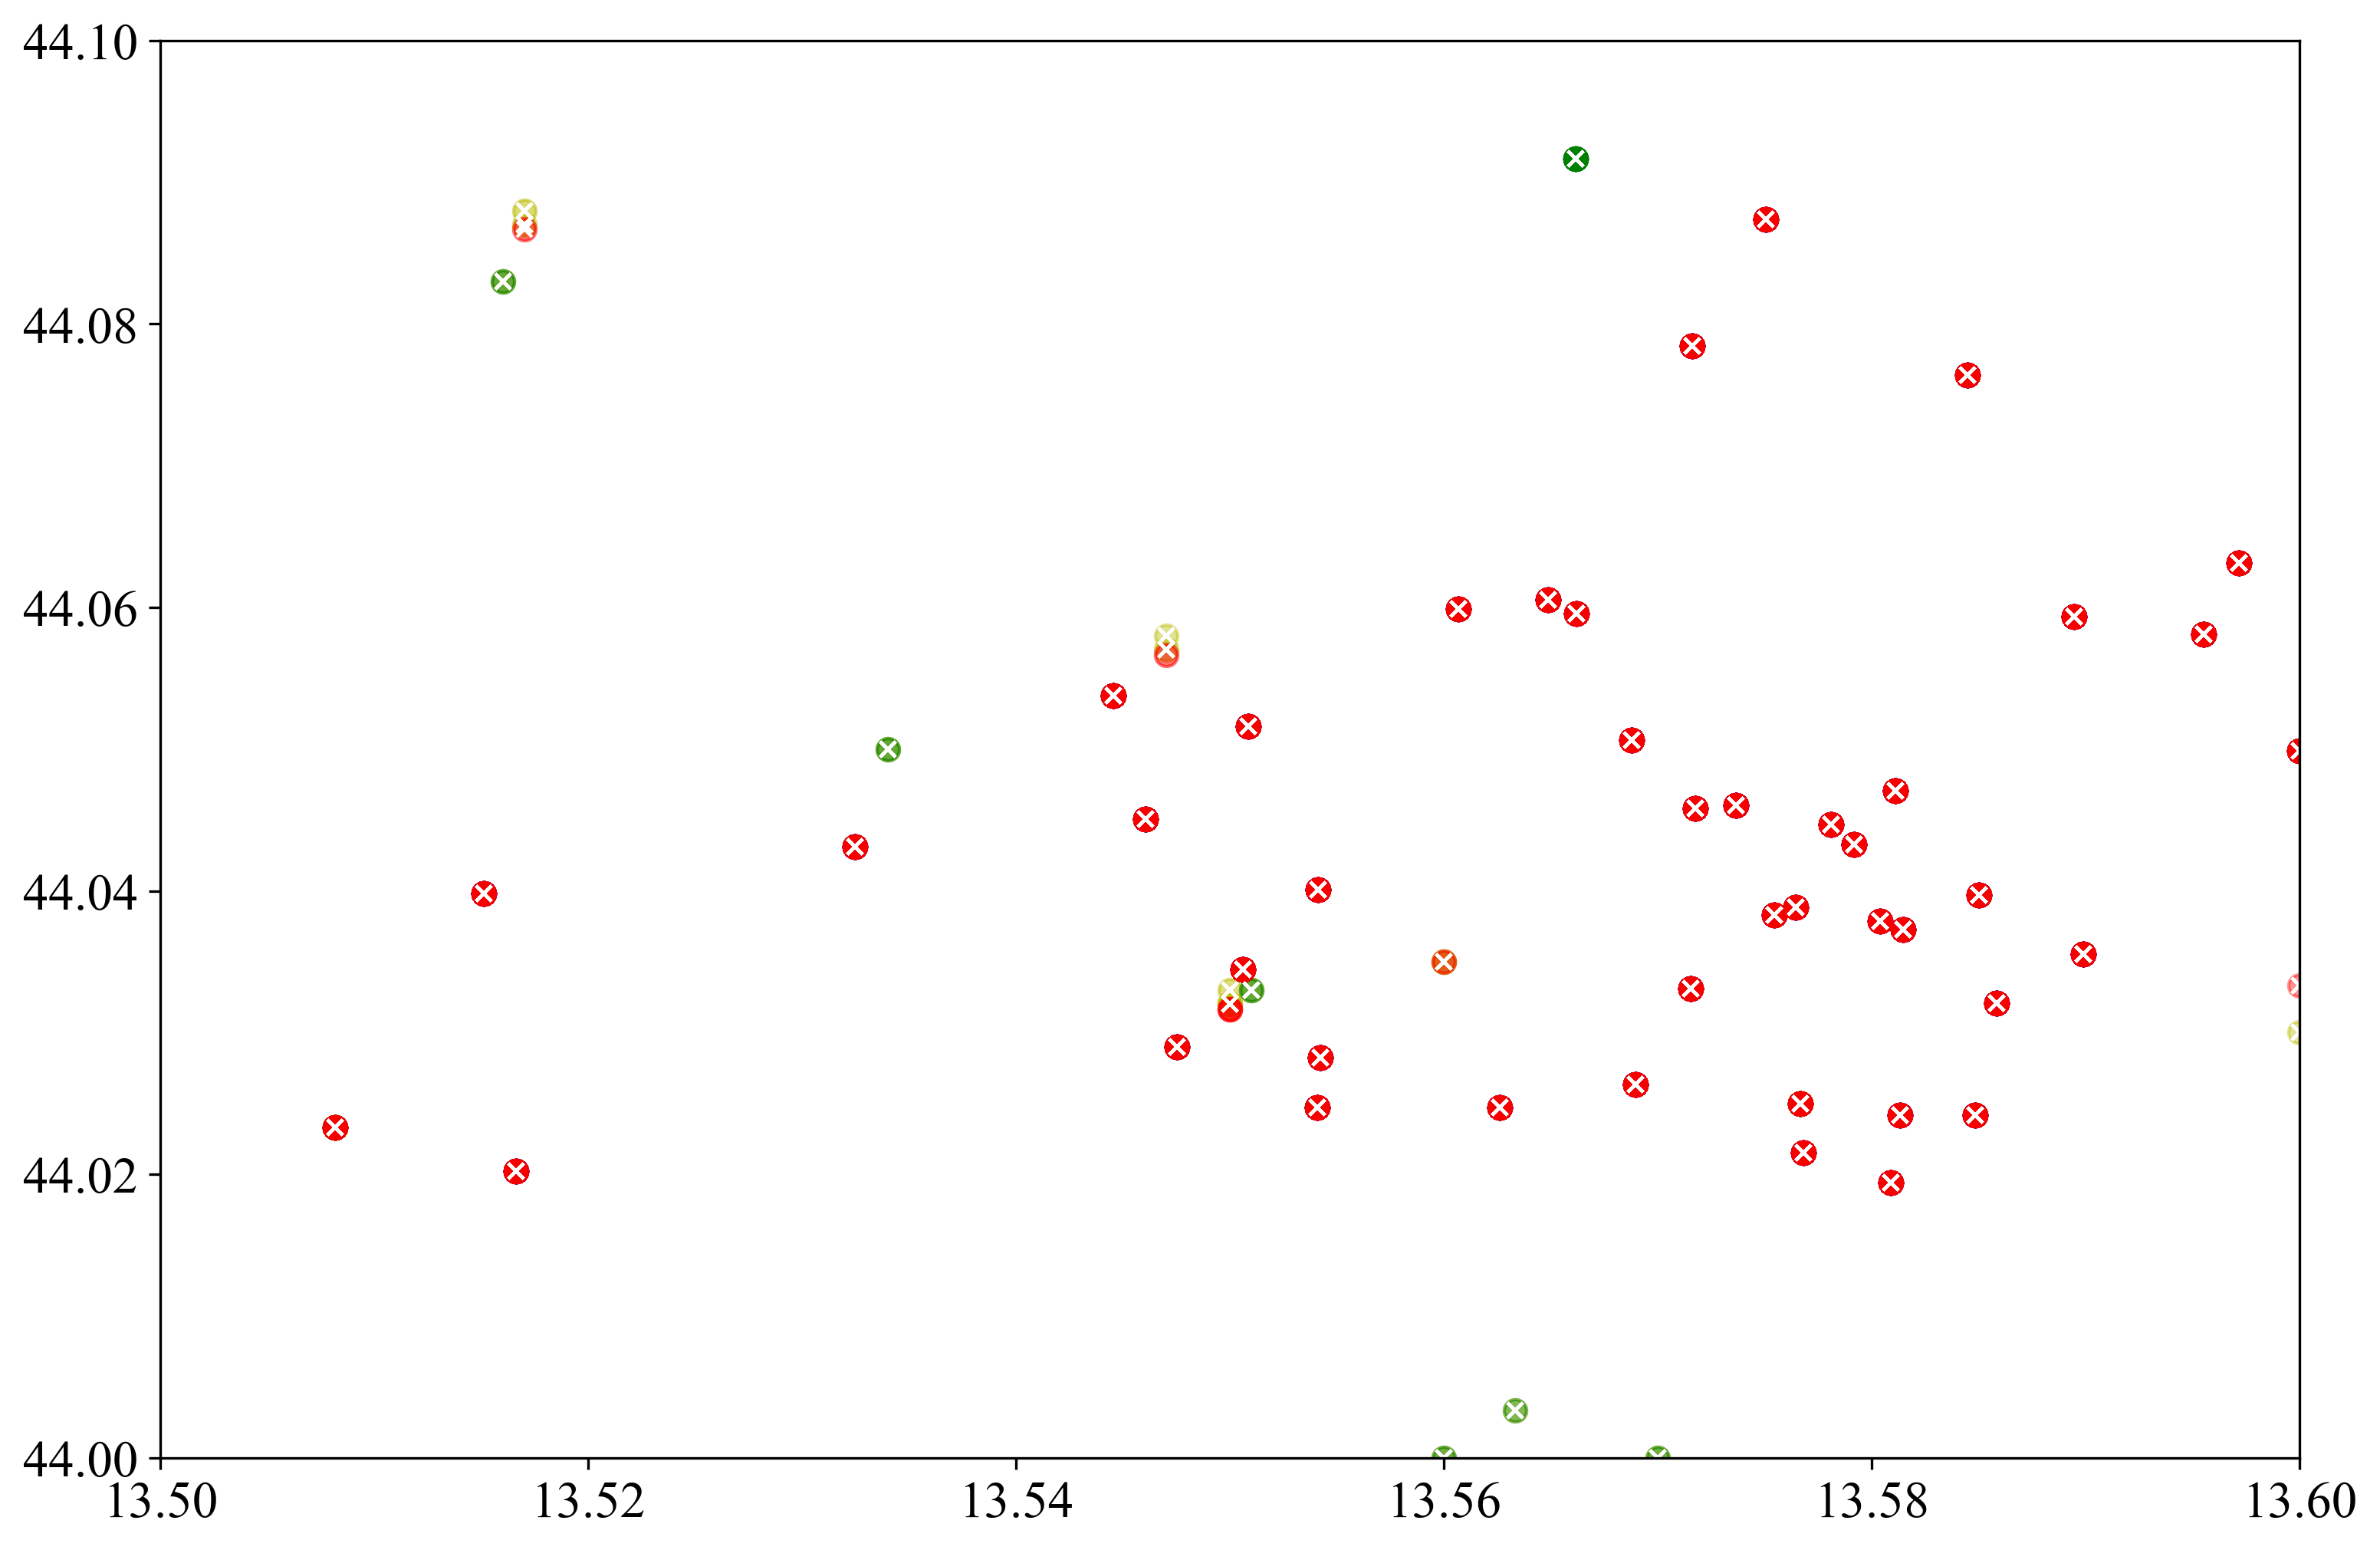

In [61]:
colorlist = ["y", "b", "g", "r"]
fig = plt.figure()
ax = plt.subplot(111)
for ii = 1:nfiles
    ax.plot(lonall[ii], latall[ii], "o", ms=7, alpha=0.1, color=colorlist[ii]) 
end
ax.plot()
ax.set_xlim(13.5, 13.6)
ax.set_ylim(44., 44.1)
ax.plot(obslon, obslat, "wx", ms=5)
plt.show()